# AnÃ¡lisis de residuos

> AnÃ¡lisis de residuos para el primer dÃ­a predicho en el horizonte.

In [ ]:
# [ConfiguraciÃ³n] Importaciones
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import bds


In [ ]:
# [ConfiguraciÃ³n] Lectura de archivos

# Cargar todos los archivos de residuos
archivos = glob.glob("metricas/Residuos_ventana*.csv")
archivos = sorted(archivos, key=lambda x: int(x.split("ventana")[1].split(".")[0]))
residuos_por_ventana = {int(f.split("ventana")[1].split(".")[0]): pd.read_csv(f) for f in archivos}

In [ ]:
# [Resumen] Descriptivo de residuos
for ventana, df in residuos_por_ventana.items():
    print(f"\nðŸ“¦ Ventana {ventana}")
    print(df["residuo_h1"].describe().round(4))


ðŸ“¦ Ventana 7
count    555.0000
mean      -0.0003
std        0.1938
min       -1.7662
25%       -0.0592
50%       -0.0115
75%        0.0488
max        2.7337
Name: residuo_h1, dtype: float64

ðŸ“¦ Ventana 14
count    290.0000
mean       0.0250
std        0.1305
min       -0.5262
25%       -0.0484
50%        0.0104
75%        0.0956
max        0.5236
Name: residuo_h1, dtype: float64

ðŸ“¦ Ventana 21
count    195.0000
mean       0.0073
std        0.0707
min       -0.2264
25%       -0.0363
50%        0.0021
75%        0.0392
max        0.2972
Name: residuo_h1, dtype: float64

ðŸ“¦ Ventana 28
count    146.0000
mean       0.0201
std        0.2402
min       -0.3808
25%       -0.0904
50%       -0.0112
75%        0.0737
max        1.4838
Name: residuo_h1, dtype: float64


La distribuciÃ³n de residuos arroja que la ventana de 7 dÃ­as tiene la mayor dispersiÃ³n y un rango extremo (Â±2.7), lo que sugiere que el modelo estÃ¡ capturando variabilidad pero tambiÃ©n generando residuos extremos. Esto puede indicar sobreajuste o sensibilidad a ruido. La ventana 21 muestra la menor desviaciÃ³n estÃ¡ndar y una media cercana a cero, lo que sugiere buena estabilidad y balance, confirmando que esta es la ventana que mejor resultado ofrece para la predicciÃ³n de volatilidad. Por otro lado, la ventana 28 tiene una desviaciÃ³n alta pero un rango mÃ¡s contenido que ventana 7, lo que podrÃ­a reflejar mayor complejidad en la dinÃ¡mica temporal.
Todas las medias estÃ¡n cerca de cero, lo cual es deseable en residuos.

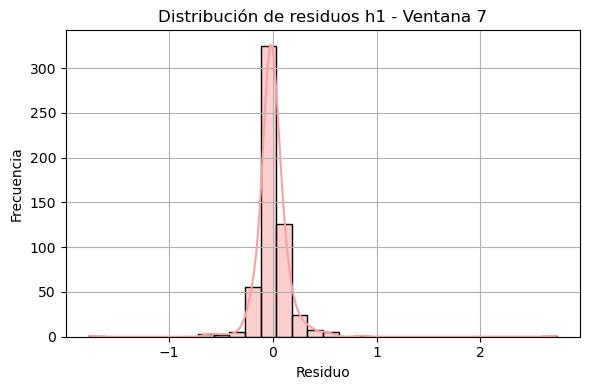

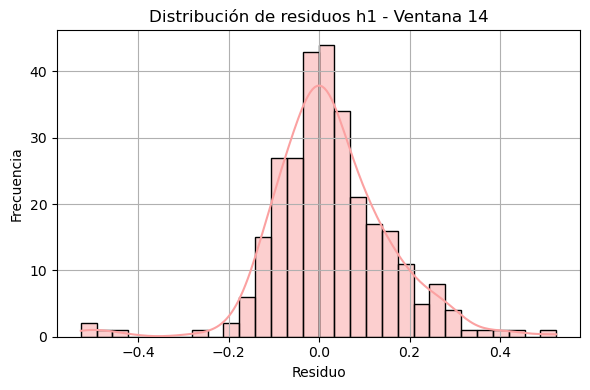

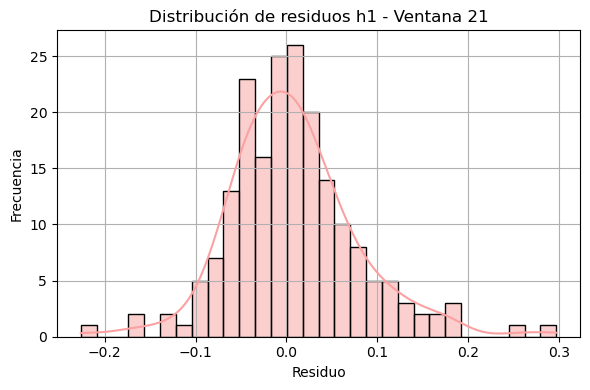

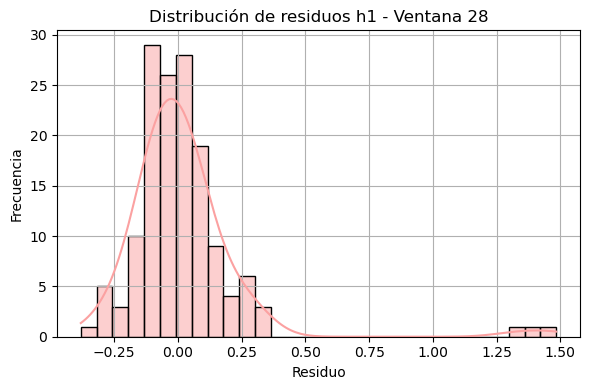

In [29]:
# [GrÃ¡fico] DistribuciÃ³n de residuos para el horizonte 1
for ventana, df in residuos_por_ventana.items():
    plt.figure(figsize=(6, 4))
    sns.histplot(df["residuo_h1"], kde=True, bins=30, color= '#FBA1A1')
    plt.title(f"DistribuciÃ³n de residuos h1 - Ventana {ventana}")
    plt.xlabel("Residuo")
    plt.ylabel("Frecuencia")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# [Test] Prueba Shapiro - BDS - Ljung-Box
for ventana, df in residuos_por_ventana.items():
    residuos = df["residuo_h1"].dropna()

    stat_shapiro, p_shapiro = shapiro(residuos)
    stat_bds = bds(residuos)
    lb_test = acorr_ljungbox(residuos, lags=[10], return_df=True)

    print(f"\nðŸ§ª Ventana {ventana}")
    print(f"Shapiro-Wilk: \n EstadÃ­stico={stat_shapiro:.4f},    P-valor={p_shapiro:.4f}")
    print(f"BDS: \n EstadÃ­stico={stat_bds[0]:.4f},  P-valor={stat_bds[1]:.4f}")
    print(f"Ljung-Box (lag 10): \n P-valor={lb_test['lb_pvalue'].values[0]:.4f}")


ðŸ§ª Ventana 7
Shapiro-Wilk: 
 EstadÃ­stico=0.6092,    P-valor=0.0000
BDS: 
 EstadÃ­stico=-0.2347,  P-valor=0.8145
Ljung-Box (lag 10): 
 P-valor=0.1599

ðŸ§ª Ventana 14
Shapiro-Wilk: 
 EstadÃ­stico=0.9425,    P-valor=0.0000
BDS: 
 EstadÃ­stico=-1.3053,  P-valor=0.1918
Ljung-Box (lag 10): 
 P-valor=0.0000

ðŸ§ª Ventana 21
Shapiro-Wilk: 
 EstadÃ­stico=0.9607,    P-valor=0.0000
BDS: 
 EstadÃ­stico=1.1136,  P-valor=0.2654
Ljung-Box (lag 10): 
 P-valor=0.0004

ðŸ§ª Ventana 28
Shapiro-Wilk: 
 EstadÃ­stico=0.6428,    P-valor=0.0000
BDS: 
 EstadÃ­stico=-1.2602,  P-valor=0.2076
Ljung-Box (lag 10): 
 P-valor=0.0017


- Normalidad: 
    Todos los residuos fallan el test de Shapiro-Wilk (p < 0.05), indicando que no siguen una distribuciÃ³n normal. 

- Dependencia no lineal (BDS):
    La ventana 7 tiene p > 0.8 â†’ no hay evidencia de estructura no lineal.
    Las demÃ¡s ventanas tienen p valor entre 0.19 y 0.26, es decir, no se rechaza la hipÃ³tesis nula, pero tampoco se confirma independencia total.

- AutocorrelaciÃ³n (Ljung-Box):
    La ventana 7 pasa el test (p > 0.05), pero las demÃ¡s lo fallan. Hay evidencia de autocorrelaciÃ³n residual, especialmente en ventanas mÃ¡s largas.

In [ ]:
# [Resumen] Promedio de residuos por fold
for ventana, df in residuos_por_ventana.items():
    promedio_por_fold = df.groupby("fold")["residuo_h1"].mean().round(4)
    print(f"\nðŸ“Š Promedio residuos h1 por fold - Ventana {ventana}")
    print(promedio_por_fold)


ðŸ“Š Promedio residuos h1 por fold - Ventana 7
fold
0    0.0031
1   -0.0160
2   -0.0177
3   -0.0214
4    0.0504
Name: residuo_h1, dtype: float64

ðŸ“Š Promedio residuos h1 por fold - Ventana 14
fold
0    0.0272
1    0.0170
2    0.0614
3   -0.0021
4    0.0213
Name: residuo_h1, dtype: float64

ðŸ“Š Promedio residuos h1 por fold - Ventana 21
fold
0    0.0190
1    0.0175
2   -0.0084
3    0.0109
4   -0.0027
Name: residuo_h1, dtype: float64

ðŸ“Š Promedio residuos h1 por fold - Ventana 28
fold
0    0.0539
1    0.0452
2    0.0393
3   -0.0097
4   -0.0264
Name: residuo_h1, dtype: float64
